### Autoregressive (AR) Model

In [108]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
register_matplotlib_converters()

### Ice Cream Production Data

In [97]:
s_icecream = pd.read_csv('Data/ice_cream.csv', parse_dates=[0], index_col=0, 
                          date_format='%Y-%m-%d').squeeze()

In [98]:
s_icecream.rename('Production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: Production, Length: 577, dtype: float64

In [99]:
s_icecream.index.rename('Date', inplace=True)

In [100]:
# Infer frequency of data => beginning of month
s_icecream = s_icecream.asfreq(pd.infer_freq(s_icecream.index))

In [101]:
# Just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
s_icecream = s_icecream[start_date:]

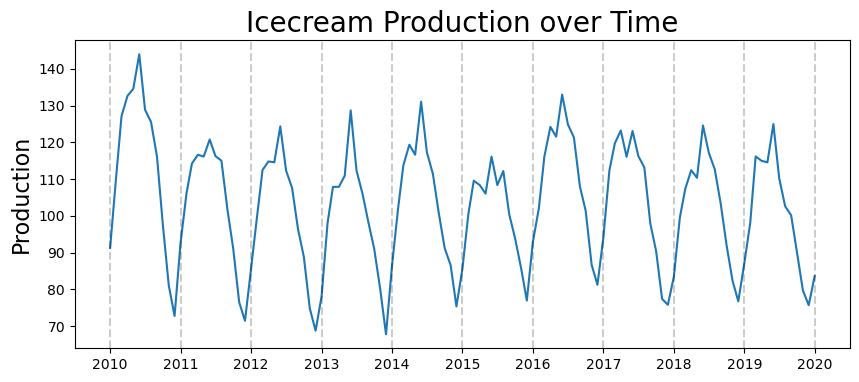

In [102]:
plt.figure(figsize=(10,4))
plt.plot(s_icecream)
plt.title('Icecream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2010, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=.2)

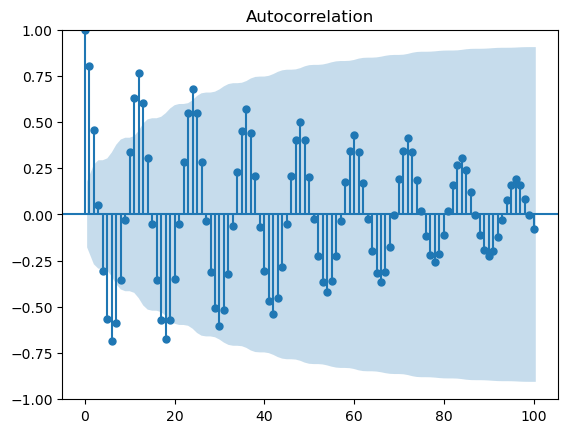

In [103]:
acf_plot = plot_acf(s_icecream, lags=100)

Decaying ACF => Autoregressive Process

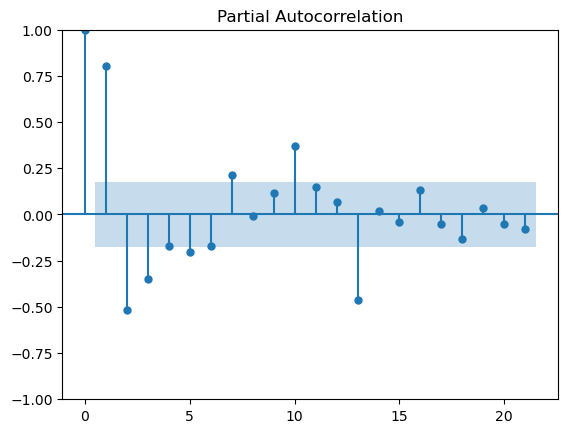

In [105]:
pacf_plot = plot_pacf(s_icecream)

#### AR Modeling

Based on the PACF, we should start with an AR-3 Model: $X_t = \beta_0+\beta_1X_{t-1}+\beta_2X_{t-2}+\beta_3X_{t-3}+\varepsilon_t$

In [106]:
# Get training and testing sets
train_end = datetime(2018, 12, 1)
test_end = datetime(2019, 12, 1)

s_train = s_icecream[:train_end]
s_test = s_icecream[train_end + timedelta(days=1):test_end]

In [110]:
# Create the model
ar_model = ARIMA(s_train, order=(3,0,0)) # 3 lags, no differences and moving averages

In [113]:
# Fit the model
start = time()
ar_fit = ar_model.fit()
end = time()
print('Model fitting time:', end - start, 's')

Model fitting time: 0.03262519836425781 s


In [114]:
# Summary of the model
print(ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Tue, 10 Sep 2024   AIC                            758.170
Time:                        21:25:56   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

We can see that the second lag is not statistically significantly different from zero.

In [116]:
# Get predictions and residuals
preds = ar_fit.predict(start=s_test.index[0], end=s_test.index[-1])
residuals = s_test - preds

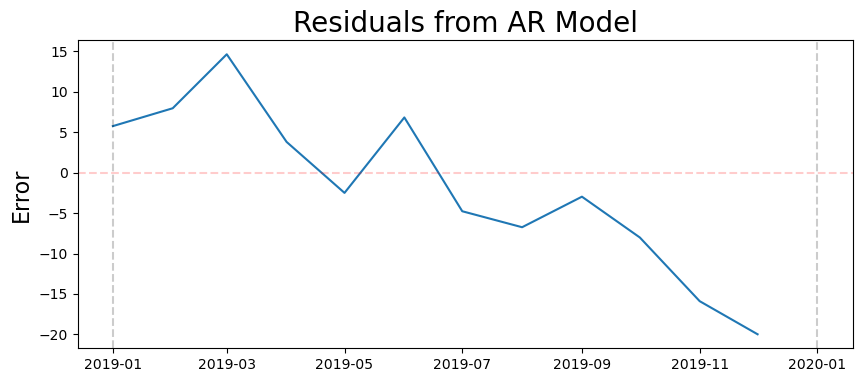

In [117]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=.2)
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=.2)

While the residuals are centered around zero, they are decreasing over time. Hence, there is a clear pattern in the residuals which indicates that there is something in the dynamics of the data that is not captured by the AR-3 model.

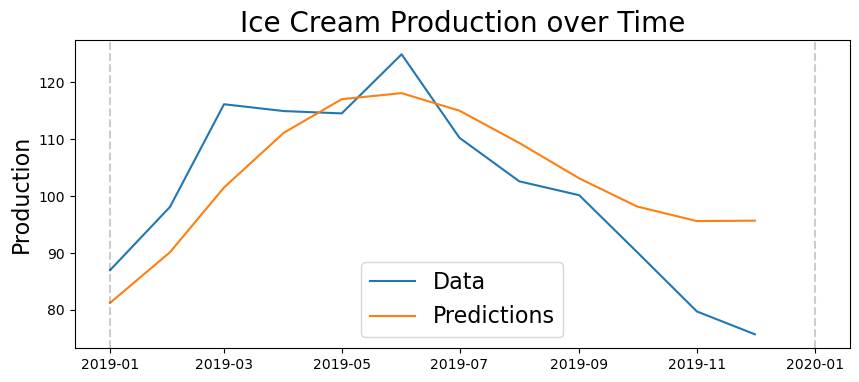

In [118]:
plt.figure(figsize=(10,4))
plt.plot(s_test)
plt.plot(preds)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=.2)

We can see that the residuals become larger over time, which is common in time-series analysis.

In [122]:
# On average, what percent away are we from our actual target?
print('Mean Absolute Percent Error:', 100 * round(np.mean(abs(residuals/s_test)), 4))

Mean Absolute Percent Error: 8.95


In [121]:
# On average, how many units away are we from our actual target?
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals ** 2)))

Root Mean Squared Error: 9.884158751641268
